### Importando os Pacotes Utilitários

In [1]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
from sklearn.model_selection import train_test_split
from distutils.dir_util import copy_tree
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import tarfile, os
import numpy as np
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Baixando os Conjuntos de Dados

In [3]:
shutil.unpack_archive(filename = '/content/drive/MyDrive/datasets-lung-loc/CheXpert-v1.0-small.zip', 
                      extract_dir = '/content/CheXpert-v1.0-small', format = 'zip')
shutil.unpack_archive(filename = '/content/drive/MyDrive/datasets-lung-loc/vinbigdata.zip', 
                      extract_dir = '/content/vinbigdata/', format = 'zip')
shutil.unpack_archive(filename = '/content/drive/MyDrive/datasets-lung-loc/images.zip', 
                      extract_dir = '/content/images/', format = 'zip')

### Organizando e Analisando os Dados

Text(0, 0.5, 'Imagens')

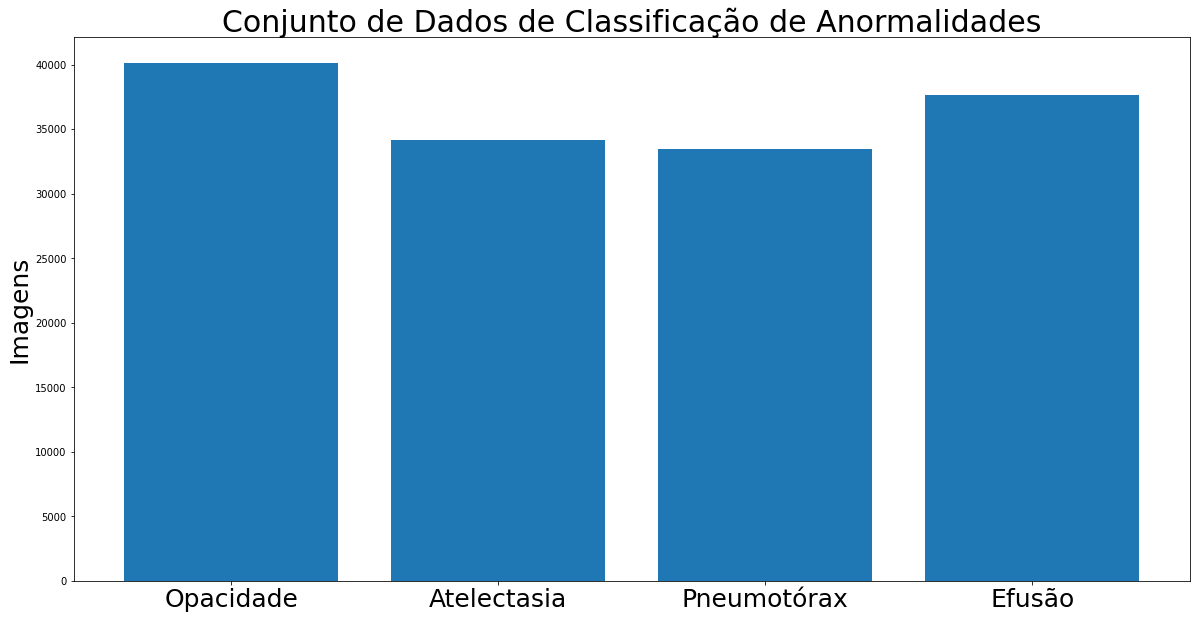

In [26]:
dataset = pd.read_csv('/content/dataset_ab_classification.csv', index_col = 0)
dataset = dataset[dataset['Abnormal'] == 1.0]

findings = ['Opacity', 'Atelectasis', 'Pneumothorax', 'Effusion']

count_findings = list()
for finding in findings:
    count = dict(dataset[finding].value_counts())[1.0]
    count_findings.append(count)

findings_pt = ['Opacidade', 'Atelectasia', 'Pneumotórax', 'Efusão']

plt.figure(figsize = (20, 10))
plt.bar(findings_pt, count_findings)
plt.xticks(rotation = 0, size = 25)
plt.title('Conjunto de Dados de Classificação de Anormalidades', size = 30)
plt.ylabel('Imagens', size = 25)

In [27]:
opacity = np.array(dataset['Opacity']).astype(str)
atelectasis = np.array(dataset['Atelectasis']).astype(str)
pneumothorax = np.array(dataset['Pneumothorax']).astype(str)
effusion = np.array(dataset['Effusion']).astype(str)

all_labels = np.zeros(effusion.shape).astype(str)
for index in range(0, len(opacity)):
  all_labels[index] = opacity[index] + atelectasis[index] + pneumothorax[index]
  all_labels[index] += effusion[index]

dataset['labels_ref'] = all_labels

In [28]:
f_train, f_val = train_test_split(dataset, test_size = 0.15, random_state = 42, 
                                  stratify = dataset['labels_ref'])
f_val, f_test = train_test_split(f_val, test_size = 0.5, random_state = 42, 
                                 stratify = f_val['labels_ref'])

f_train.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_val.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_test.drop(labels = ['labels_ref'], axis = 1, inplace = True)

Text(0, 0.5, 'Imagens')

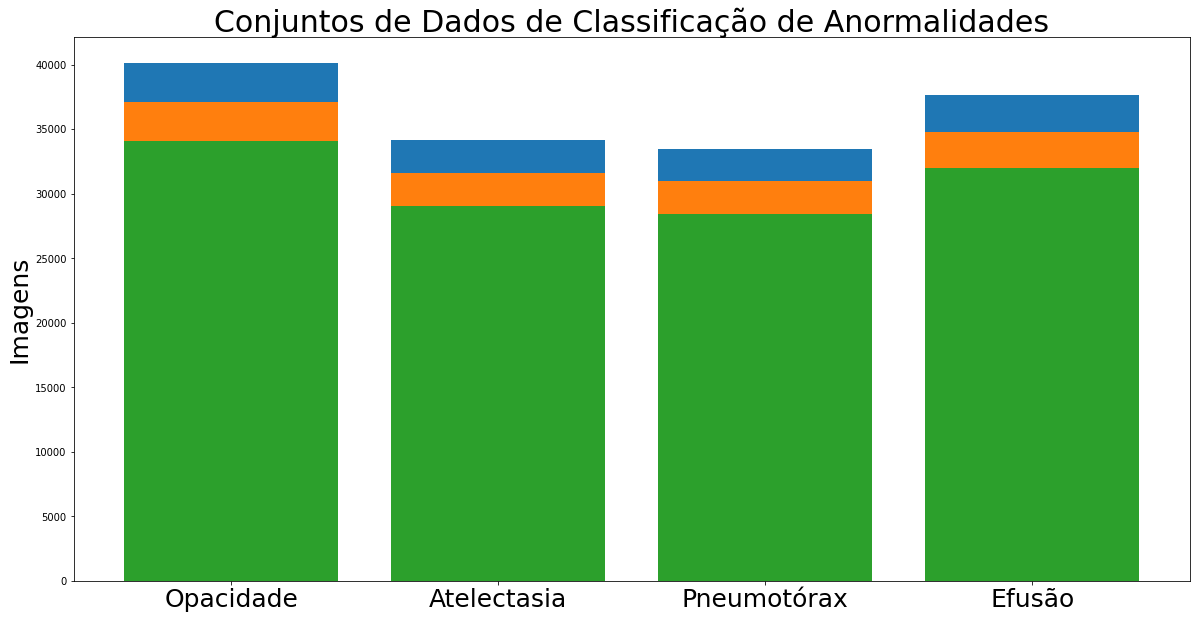

In [29]:
count_train, count_val, count_test = [], [], []
for finding in list(f_train.columns)[4:-1]:
  c_train = dict(f_train[finding].value_counts())[1.0]
  c_val = dict(f_val[finding].value_counts())[1.0]
  c_test = dict(f_test[finding].value_counts())[1.0]
  count_train.append(c_train), count_val.append(c_val), count_test.append(c_test)

plt.figure(figsize = (20, 10))
plt.bar(findings_pt, np.sum((count_train, count_val, count_test), axis = 0))
plt.bar(findings_pt, np.sum((count_train, count_val), axis = 0))
plt.bar(findings_pt, count_train)
plt.xticks(rotation = 0, size = 25)
plt.title('Conjuntos de Dados de Classificação de Anormalidades', size = 30)
plt.ylabel('Imagens', size = 25)

### Gerador de Imagens do Keras

In [30]:
image_size, batch_size = 224, 64

In [31]:
core_idg_train1 = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input, 
                                     rotation_range = 3, width_shift_range = 0.05, height_shift_range = 0.05, 
                                     fill_mode = 'constant')
core_idg_train2 = ImageDataGenerator(preprocessing_function = tf.keras.applications.densenet.preprocess_input, 
                                     rotation_range = 3, width_shift_range = 0.05, height_shift_range = 0.05, 
                                     fill_mode = 'constant')
core_idg_train3 = ImageDataGenerator(preprocessing_function = tf.keras.applications.inception_v3.preprocess_input, 
                                     rotation_range = 3, width_shift_range = 0.05, height_shift_range = 0.05, 
                                     fill_mode = 'constant')
core_idg_train4 = ImageDataGenerator(preprocessing_function = tf.keras.applications.xception.preprocess_input, 
                                     rotation_range = 3, width_shift_range = 0.05, height_shift_range = 0.05, 
                                     fill_mode = 'constant')
core_idg_train5 = ImageDataGenerator(preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input, 
                                     rotation_range = 3, width_shift_range = 0.05, height_shift_range = 0.05, 
                                     fill_mode = 'constant')
core_idg_train6 = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet_v2.preprocess_input, 
                                     rotation_range = 3, width_shift_range = 0.05, height_shift_range = 0.05, 
                                     fill_mode = 'constant')

In [32]:
core_idg_test1 = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)
core_idg_test2 = ImageDataGenerator(preprocessing_function = tf.keras.applications.densenet.preprocess_input)
core_idg_test3 = ImageDataGenerator(preprocessing_function = tf.keras.applications.inception_v3.preprocess_input)
core_idg_test4 = ImageDataGenerator(preprocessing_function = tf.keras.applications.xception.preprocess_input)
core_idg_test5 = ImageDataGenerator(preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input)
core_idg_test6 = ImageDataGenerator(preprocessing_function = tf.keras.applications.resnet_v2.preprocess_input)

In [33]:
train_gen1 = core_idg_train1.flow_from_dataframe(dataframe = f_train, directory = None, 
                                                 x_col = 'Path', y_col = findings, 
                                                 class_mode = 'raw', 
                                                 batch_size = batch_size,
                                                 target_size = (image_size, image_size), 
                                                 shuffle = True)
train_gen2 = core_idg_train2.flow_from_dataframe(dataframe = f_train, directory = None, 
                                                 x_col = 'Path', y_col = findings, 
                                                 class_mode = 'raw', 
                                                 batch_size = batch_size,
                                                 target_size = (image_size, image_size), 
                                                 shuffle = True)
train_gen3 = core_idg_train3.flow_from_dataframe(dataframe = f_train, directory = None, 
                                                 x_col = 'Path', y_col = findings, 
                                                 class_mode = 'raw', 
                                                 batch_size = batch_size,
                                                 target_size = (image_size, image_size), 
                                                 shuffle = True)
train_gen4 = core_idg_train4.flow_from_dataframe(dataframe = f_train, directory = None, 
                                                 x_col = 'Path', y_col = findings, 
                                                 class_mode = 'raw', 
                                                 batch_size = batch_size,
                                                 target_size = (image_size, image_size), 
                                                 shuffle = True)
train_gen5 = core_idg_train5.flow_from_dataframe(dataframe = f_train, directory = None, 
                                                 x_col = 'Path', y_col = findings, 
                                                 class_mode = 'raw', 
                                                 batch_size = batch_size,
                                                 target_size = (image_size, image_size), 
                                                 shuffle = True)
train_gen6 = core_idg_train6.flow_from_dataframe(dataframe = f_train, directory = None, 
                                                 x_col = 'Path', y_col = findings, 
                                                 class_mode = 'raw', 
                                                 batch_size = batch_size,
                                                 target_size = (image_size, image_size), 
                                                 shuffle = True)

Found 67089 validated image filenames.
Found 67089 validated image filenames.
Found 67089 validated image filenames.
Found 67089 validated image filenames.
Found 67089 validated image filenames.
Found 67089 validated image filenames.


In [34]:
valid_gen1 = core_idg_test1.flow_from_dataframe(dataframe = f_val, directory = None, 
                                                x_col = 'Path',  y_col = findings, 
                                                class_mode = 'raw', 
                                                batch_size = batch_size,
                                                target_size = (image_size, image_size),
                                                shuffle = False)
valid_gen2 = core_idg_test2.flow_from_dataframe(dataframe = f_val, directory = None, 
                                                x_col = 'Path',  y_col = findings, 
                                                class_mode = 'raw', 
                                                batch_size = batch_size,
                                                target_size = (image_size, image_size),
                                                shuffle = False)
valid_gen3 = core_idg_test3.flow_from_dataframe(dataframe = f_val, directory = None, 
                                                x_col = 'Path',  y_col = findings, 
                                                class_mode = 'raw', 
                                                batch_size = batch_size,
                                                target_size = (image_size, image_size),
                                                shuffle = False)
valid_gen4 = core_idg_test4.flow_from_dataframe(dataframe = f_val, directory = None, 
                                                x_col = 'Path',  y_col = findings, 
                                                class_mode = 'raw', 
                                                batch_size = batch_size,
                                                target_size = (image_size, image_size),
                                                shuffle = False)
valid_gen5 = core_idg_test5.flow_from_dataframe(dataframe = f_val, directory = None, 
                                                x_col = 'Path',  y_col = findings, 
                                                class_mode = 'raw', 
                                                batch_size = batch_size,
                                                target_size = (image_size, image_size),
                                                shuffle = False)
valid_gen6 = core_idg_test6.flow_from_dataframe(dataframe = f_val, directory = None, 
                                                x_col = 'Path',  y_col = findings, 
                                                class_mode = 'raw', 
                                                batch_size = batch_size,
                                                target_size = (image_size, image_size),
                                                shuffle = False)

y_labels_valid1 = valid_gen1.labels
y_labels_valid2 = valid_gen2.labels
y_labels_valid3 = valid_gen3.labels
y_labels_valid4 = valid_gen4.labels
y_labels_valid5 = valid_gen5.labels
y_labels_valid6 = valid_gen6.labels

Found 5920 validated image filenames.
Found 5920 validated image filenames.
Found 5920 validated image filenames.
Found 5920 validated image filenames.
Found 5920 validated image filenames.
Found 5920 validated image filenames.


In [35]:
test_gen1 = core_idg_test1.flow_from_dataframe(dataframe = f_test, directory = None, 
                                               x_col = 'Path', y_col = findings, 
                                               class_mode = 'raw', batch_size = batch_size,
                                               target_size = (image_size, image_size),
                                               shuffle = False)
test_gen2 = core_idg_test2.flow_from_dataframe(dataframe = f_test, directory = None, 
                                               x_col = 'Path', y_col = findings, 
                                               class_mode = 'raw', batch_size = batch_size,
                                               target_size = (image_size, image_size),
                                               shuffle = False)
test_gen3 = core_idg_test3.flow_from_dataframe(dataframe = f_test, directory = None, 
                                               x_col = 'Path', y_col = findings, 
                                               class_mode = 'raw', batch_size = batch_size,
                                               target_size = (image_size, image_size),
                                               shuffle = False)                                                                                             
test_gen4 = core_idg_test4.flow_from_dataframe(dataframe = f_test, directory = None, 
                                               x_col = 'Path', y_col = findings, 
                                               class_mode = 'raw', batch_size = batch_size,
                                               target_size = (image_size, image_size),
                                               shuffle = False)
test_gen5 = core_idg_test5.flow_from_dataframe(dataframe = f_test, directory = None, 
                                               x_col = 'Path', y_col = findings, 
                                               class_mode = 'raw', batch_size = batch_size,
                                               target_size = (image_size, image_size),
                                               shuffle = False)
test_gen6 = core_idg_test6.flow_from_dataframe(dataframe = f_test, directory = None, 
                                               x_col = 'Path', y_col = findings, 
                                               class_mode = 'raw', batch_size = batch_size,
                                               target_size = (image_size, image_size),
                                               shuffle = False)

y_labels_test1 = test_gen1.labels
y_labels_test2 = test_gen2.labels
y_labels_test3 = test_gen3.labels
y_labels_test4 = test_gen4.labels
y_labels_test5 = test_gen5.labels
y_labels_test6 = test_gen6.labels

Found 5920 validated image filenames.
Found 5920 validated image filenames.
Found 5920 validated image filenames.
Found 5920 validated image filenames.
Found 5920 validated image filenames.
Found 5920 validated image filenames.


### Organizando uma Função Utilitária de Callback

In [36]:
def get_callbacks(model_name, monitor = 'val_acc'):
    '''
    gerando uma lista de callbacks úteis para o treinamento da rede

    Args:
        model_name (str) --> nome do modelo em análise
        monitor (str) --> métrica de análise a ser monitorada pelo callback

    Returns:
        callbacks (list) --> Lista de callbacks
    '''
    checkpoint_file = f'model.{model_name}.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_file,
                                                    verbose = 1, 
                                                    save_best_only = True, 
                                                    monitor = monitor, 
                                                    mode = 'max')
    
    return [checkpoint]

### Definindo uma Função de Congelamento de Camadas

In [37]:
def freeze_layers(conv_base, layer_name):
  '''
  método de treinamento por congelamento de camadas das redes convolucionais

  Args:
    conv_base (tensor) --> camadas convolucionais do modelo
    layer_name (str) --> nome de referência da camada a ser iniciado o 
    congelamento
  '''

  conv_base.trainable = True
  set_trainable = False

  for layer in conv_base.layers:
    if layer.name == layer_name: set_trainable = True
    if set_trainable: layer.trainable = True
    else: layer.trainable = False
  
  return None

### Definindo uma Função de Binarização das Predições

In [38]:
def binarize_preds(pred_array, column, threshold):
  '''
  função que binariza as predições mutirrótulo do modelo

  Args:
    pred_array (array) --> vetor com as predições multirrótulo
    column (int) --> coluna do vetor multirrótulo a ser analisada
    threshold (float) --> valor de threshold a ser considerado na predição
  
  Returns:
    pred_bin (array) --> vetor de predição com os valores binarizados
  '''
  per_100 = pred_array[:,column] * 100
  pred_bin = list()
  for value in per_100:
    if value >= threshold: pred_bin.append(1)
    else: pred_bin.append(0)
  
  return pred_bin

### EfficientNetB0

In [ ]:
base_model1 = EfficientNetB0(include_top = False, weights = 'imagenet', 
                             input_shape = (image_size, image_size, 3))
x = base_model1.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(findings), activation = 'sigmoid')(x)
efficientnet = tf.keras.Model(base_model1.input, output)
efficientnet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                     loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                     metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks(model_name = 'efficientnet', monitor = 'val_auc_5')

In [116]:
layers_name = list()
for layer in base_model1.layers:
  layers_name.append(layer.name)

block_names = ['block4a_dwconv_pad', 'block5c_project_conv', 'block7a_project_bn']

for blocks in block_names:
  try:
    layers_name.index(blocks)
    print('Bloco ' + blocks + ' found!')
  except ValueError:
    print('Bloco ' + blocks + ' not found!')

Bloco block4a_dwconv_pad found!
Bloco block5c_project_conv found!
Bloco block7a_project_bn found!


In [117]:
freeze_layers(conv_base = base_model1, layer_name = block_names[2])
efficientnet.fit(train_gen1, validation_data = valid_gen1, epochs = 5, 
                 callbacks = callbacks, use_multiprocessing = True, 
                 workers = 8)

Epoch 1/5
1049/1049 [==============================] - ETA: 0s - loss: 0.5332 - auc_5: 0.7950
Epoch 1: val_auc_5 improved from -inf to 0.79755, saving model to model.efficientnet.h5
1049/1049 [==============================] - 601s 558ms/step - loss: 0.5332 - auc_5: 0.7950 - val_loss: 0.5627 - val_auc_5: 0.7975
Epoch 2/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4905 - auc_5: 0.8310
Epoch 2: val_auc_5 improved from 0.79755 to 0.81626, saving model to model.efficientnet.h5
1049/1049 [==============================] - 573s 541ms/step - loss: 0.4905 - auc_5: 0.8310 - val_loss: 0.5637 - val_auc_5: 0.8163
Epoch 3/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4683 - auc_5: 0.8470
Epoch 3: val_auc_5 did not improve from 0.81626
1049/1049 [==============================] - 580s 547ms/step - loss: 0.4683 - auc_5: 0.8470 - val_loss: 0.5875 - val_auc_5: 0.8124
Epoch 4/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4482 - auc_5: 0.8608
Epoc

In [ ]:
efficientnet.load_weights('/content/model.efficientnet.h5')
efficientnet.save('model_efficientnet1')
shutil.make_archive(base_name = 'model_efficientnet1', format = 'zip', 
                    root_dir = '/content/model_efficientnet1')
shutil.move('/content/model_efficientnet1.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/EfficientNetB0')

In [119]:
freeze_layers(conv_base = base_model1, layer_name = block_names[1])
efficientnet.fit(train_gen1, validation_data = valid_gen1, epochs = 5, 
                 callbacks = callbacks, use_multiprocessing = True, 
                 workers = 8)

Epoch 1/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4044 - auc_5: 0.8883
Epoch 1: val_auc_5 did not improve from 0.85537
1049/1049 [==============================] - 604s 571ms/step - loss: 0.4044 - auc_5: 0.8883 - val_loss: 0.5864 - val_auc_5: 0.8295
Epoch 2/5
1049/1049 [==============================] - ETA: 0s - loss: 0.3783 - auc_5: 0.9031
Epoch 2: val_auc_5 improved from 0.85537 to 0.86203, saving model to model.efficientnet.h5
1049/1049 [==============================] - 626s 591ms/step - loss: 0.3783 - auc_5: 0.9031 - val_loss: 0.4807 - val_auc_5: 0.8620
Epoch 3/5
1049/1049 [==============================] - ETA: 0s - loss: 0.3553 - auc_5: 0.9148
Epoch 3: val_auc_5 improved from 0.86203 to 0.86294, saving model to model.efficientnet.h5
1049/1049 [==============================] - 596s 563ms/step - loss: 0.3553 - auc_5: 0.9148 - val_loss: 0.5133 - val_auc_5: 0.8629
Epoch 4/5
1049/1049 [==============================] - ETA: 0s - loss: 0.3309 - auc_5: 0.9263
E

In [ ]:
efficientnet.load_weights('/content/model.efficientnet.h5')
efficientnet.save('model_efficientnet2')
shutil.make_archive(base_name = 'model_efficientnet2', format = 'zip', 
                    root_dir = '/content/model_efficientnet2')
shutil.move('/content/model_efficientnet2.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/EfficientNetB0')

In [121]:
freeze_layers(conv_base = base_model1, layer_name = block_names[0])
efficientnet.fit(train_gen1, validation_data = valid_gen1, epochs = 5, 
                 callbacks = callbacks, use_multiprocessing = True, 
                 workers = 8)

Epoch 1/5
1049/1049 [==============================] - ETA: 0s - loss: 0.3060 - auc_5: 0.9369
Epoch 1: val_auc_5 improved from 0.86759 to 0.88123, saving model to model.efficientnet.h5
1049/1049 [==============================] - 594s 562ms/step - loss: 0.3060 - auc_5: 0.9369 - val_loss: 0.4768 - val_auc_5: 0.8812
Epoch 2/5
1049/1049 [==============================] - ETA: 0s - loss: 0.2897 - auc_5: 0.9436
Epoch 2: val_auc_5 improved from 0.88123 to 0.89113, saving model to model.efficientnet.h5
1049/1049 [==============================] - 608s 572ms/step - loss: 0.2897 - auc_5: 0.9436 - val_loss: 0.4570 - val_auc_5: 0.8911
Epoch 3/5
1049/1049 [==============================] - ETA: 0s - loss: 0.2708 - auc_5: 0.9508
Epoch 3: val_auc_5 did not improve from 0.89113
1049/1049 [==============================] - 563s 531ms/step - loss: 0.2708 - auc_5: 0.9508 - val_loss: 0.5913 - val_auc_5: 0.8680
Epoch 4/5
1049/1049 [==============================] - ETA: 0s - loss: 0.2555 - auc_5: 0.9561
E

In [ ]:
efficientnet.load_weights('/content/model.efficientnet.h5')
efficientnet.save('model_efficientnet3')
shutil.make_archive(base_name = 'model_efficientnet3', format = 'zip', 
                    root_dir = '/content/model_efficientnet3')
shutil.move('/content/model_efficientnet3.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/EfficientNetB0')

In [ ]:
shutil.move('/content/model.efficientnet.h5', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/EfficientNetB0')

In [124]:
y_pred_val1 = efficientnet.predict(valid_gen1)
y_pred1 = efficientnet.predict(test_gen1)
print(f'AUC | Dados de Validação = {efficientnet.evaluate(valid_gen1)[1] * 100} %')
print(f'AUC | Dados de Teste = {efficientnet.evaluate(test_gen1)[1] * 100} %')

93/93 [==============================] - 32s 341ms/step - loss: 0.4570 - auc_5: 0.8911
AUC | Dados de Validação = 89.11292552947998 %
93/93 [==============================] - 32s 339ms/step - loss: 0.4485 - auc_5: 0.8924
AUC | Dados de Teste = 89.2352819442749 %


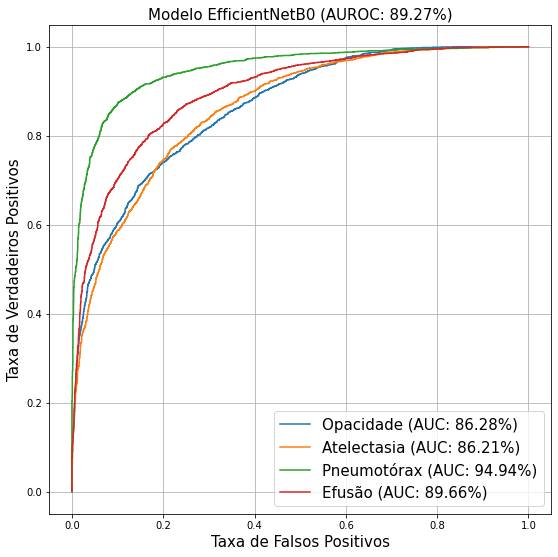

In [125]:
labels_portugues = ['Opacidade', 'Atelectasia', 'Pneumotórax', 'Efusão']
fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(y_labels_test1[:, idx].astype(int), y_pred1[:, idx])
    c_ax.plot(fpr, tpr, label = '{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize = 15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
auroc_value = str(roc_auc_score(y_labels_test1.astype(int), y_pred1)*100)[0:5]
c_ax.set_title('Modelo EfficientNetB0 (AUROC: ' + auroc_value + '%)', size = 15)
c_ax.grid(True)

In [126]:
threshold_variation = dict()
for label_index in range(0, len(findings)):
  threshold_variation[label_index] = list()
  for threshold in range(1, 100):
    y_pred_bin1 = binarize_preds(pred_array = y_pred_val1, column = label_index, 
                                 threshold = threshold)
    matrix = confusion_matrix(y_labels_valid1[:, label_index], y_pred_bin1)
    acc = (matrix[0,0] + matrix[1,1]) / np.sum(matrix)
    threshold_variation[label_index].append(acc)

bests_thresholds = list()
for label_index in range(0, len(findings)):
   for threshold in range(1, 100):
     if threshold_variation[label_index][threshold] == np.max(threshold_variation[label_index]):
       bests_thresholds.append(threshold)
       break

In [127]:
for label_index in range(0,len(findings)):
  y_pred_bin1 = binarize_preds(pred_array = y_pred1, column = label_index, 
                               threshold = bests_thresholds[label_index])
  matrix = confusion_matrix(y_labels_test1[:, label_index], y_pred_bin1)
  acc = (matrix[0,0] + matrix[1,1]) / np.sum(matrix)
  precision = matrix[0,0] / (matrix[0,0] + matrix[0,1])
  recall = matrix[0,0] / (matrix[0,0] + matrix[1,0])
  f1_score = (2 * precision * recall) / (precision + recall) 
  print(f'=={labels_portugues[label_index]}== \n{matrix},' 
        f' Threshold = {bests_thresholds[label_index]}'
        f'\nAcurácia = {acc * 100} % | Precisão = {precision * 100} % | '
        f'\nSensibilidade = {recall * 100} % | F1 Score = {f1_score * 100} %\n')

==Opacidade== 
[[2311  600]
 [ 773 2236]], Threshold = 36
Acurácia = 76.80743243243244 % | Precisão = 79.38852627962899 % | 
Sensibilidade = 74.93514915693905 % | F1 Score = 77.09758131776479 %

==Atelectasia== 
[[2716  640]
 [ 680 1884]], Threshold = 63
Acurácia = 77.7027027027027 % | Precisão = 80.92967818831943 % | 
Sensibilidade = 79.97644287396938 % | F1 Score = 80.45023696682465 %

==Pneumotórax== 
[[3116  294]
 [ 365 2145]], Threshold = 35
Acurácia = 88.86824324324324 % | Precisão = 91.3782991202346 % | 
Sensibilidade = 89.51450732548119 % | F1 Score = 90.43680162530838 %

==Efusão== 
[[2421  677]
 [ 446 2376]], Threshold = 59
Acurácia = 81.0304054054054 % | Precisão = 78.14719173660426 % | 
Sensibilidade = 84.44366934077433 % | F1 Score = 81.17351215423302 %



### DenseNet121

In [ ]:
base_model2 = DenseNet121(include_top = False, weights = 'imagenet', 
                          input_shape = (image_size, image_size, 3))
x = base_model2.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(findings), activation = 'sigmoid')(x)
densenet = tf.keras.Model(base_model2.input, output)
densenet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                 loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                 metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks(model_name = 'densenet', monitor = 'val_auc')

In [40]:
layers_name = list()
for layer in base_model2.layers:
  layers_name.append(layer.name)

block_names = ['input_1', 'conv4_block5_0_relu', 'conv5_block4_concat']

for blocks in block_names:
  try:
    layers_name.index(blocks)
    print('Bloco ' + blocks + ' found!')
  except ValueError:
    print('Bloco ' + blocks + ' not found!')

Bloco input_1 found!
Bloco conv4_block5_0_relu found!
Bloco conv5_block4_concat found!


In [41]:
freeze_layers(conv_base = base_model2, layer_name = block_names[2])
densenet.fit(train_gen2, validation_data = valid_gen2, epochs = 5, 
             callbacks = callbacks, use_multiprocessing = True, 
             workers = 8)

Epoch 1/5
1049/1049 [==============================] - ETA: 0s - loss: 0.5695 - auc: 0.7599
Epoch 1: val_auc improved from -inf to 0.77710, saving model to model.densenet.h5
1049/1049 [==============================] - 616s 559ms/step - loss: 0.5695 - auc: 0.7599 - val_loss: 0.6342 - val_auc: 0.7771
Epoch 2/5
1049/1049 [==============================] - ETA: 0s - loss: 0.5318 - auc: 0.7961
Epoch 2: val_auc did not improve from 0.77710
1049/1049 [==============================] - 544s 515ms/step - loss: 0.5318 - auc: 0.7961 - val_loss: 0.6024 - val_auc: 0.7755
Epoch 3/5
1049/1049 [==============================] - ETA: 0s - loss: 0.5162 - auc: 0.8098
Epoch 3: val_auc improved from 0.77710 to 0.78583, saving model to model.densenet.h5
1049/1049 [==============================] - 554s 524ms/step - loss: 0.5162 - auc: 0.8098 - val_loss: 0.5684 - val_auc: 0.7858
Epoch 4/5
1049/1049 [==============================] - ETA: 0s - loss: 0.5052 - auc: 0.8190
Epoch 4: val_auc improved from 0.78583

In [ ]:
densenet.load_weights('/content/model.densenet.h5')
densenet.save('model_densenet1')
shutil.make_archive(base_name = 'model_densenet1', format = 'zip', 
                    root_dir = '/content/model_densenet1')
shutil.move('/content/model_densenet1.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/DenseNet121')

In [43]:
freeze_layers(conv_base = base_model2, layer_name = block_names[1])
densenet.fit(train_gen2, validation_data = valid_gen2, epochs = 5, 
             callbacks = callbacks, use_multiprocessing = True, 
             workers = 8)

Epoch 1/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4808 - auc: 0.8384
Epoch 1: val_auc improved from 0.81102 to 0.82405, saving model to model.densenet.h5
1049/1049 [==============================] - 583s 552ms/step - loss: 0.4808 - auc: 0.8384 - val_loss: 0.5286 - val_auc: 0.8241
Epoch 2/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4693 - auc: 0.8464
Epoch 2: val_auc improved from 0.82405 to 0.82481, saving model to model.densenet.h5
1049/1049 [==============================] - 601s 567ms/step - loss: 0.4693 - auc: 0.8464 - val_loss: 0.5363 - val_auc: 0.8248
Epoch 3/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4549 - auc: 0.8565
Epoch 3: val_auc did not improve from 0.82481
1049/1049 [==============================] - 634s 601ms/step - loss: 0.4549 - auc: 0.8565 - val_loss: 0.5610 - val_auc: 0.8192
Epoch 4/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4399 - auc: 0.8665
Epoch 4: val_auc did not improve fr

In [ ]:
densenet.load_weights('/content/model.densenet.h5')
densenet.save('model_densenet2')
shutil.make_archive(base_name = 'model_densenet2', format = 'zip', 
                    root_dir = '/content/model_densenet2')
shutil.move('/content/model_densenet2.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/DenseNet121')

In [45]:
freeze_layers(conv_base = base_model2, layer_name = block_names[0])
densenet.fit(train_gen2, validation_data = valid_gen2, epochs = 5, 
             callbacks = callbacks, use_multiprocessing = True, 
             workers = 8)

Epoch 1/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4495 - auc: 0.8605
Epoch 1: val_auc did not improve from 0.82481
1049/1049 [==============================] - 576s 544ms/step - loss: 0.4495 - auc: 0.8605 - val_loss: 0.5744 - val_auc: 0.8131
Epoch 2/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4364 - auc: 0.8693
Epoch 2: val_auc improved from 0.82481 to 0.83390, saving model to model.densenet.h5
1049/1049 [==============================] - 570s 537ms/step - loss: 0.4364 - auc: 0.8693 - val_loss: 0.5382 - val_auc: 0.8339
Epoch 3/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4215 - auc: 0.8782
Epoch 3: val_auc did not improve from 0.83390
1049/1049 [==============================] - 599s 568ms/step - loss: 0.4215 - auc: 0.8782 - val_loss: 0.6128 - val_auc: 0.7990
Epoch 4/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4067 - auc: 0.8873
Epoch 4: val_auc did not improve from 0.83390
1049/1049 [=================

In [ ]:
densenet.load_weights('/content/model.densenet.h5')
densenet.save('model_densenet3')
shutil.make_archive(base_name = 'model_densenet3', format = 'zip', 
                    root_dir = '/content/model_densenet3')
shutil.move('/content/model_densenet3.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/DenseNet121')

In [ ]:
shutil.move('/content/model.densenet.h5', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/DenseNet121')

In [48]:
y_pred_val2 = densenet.predict(valid_gen2)
y_pred2 = densenet.predict(test_gen2)
print(f'AUC | Dados de Validação = {densenet.evaluate(valid_gen2)[1] * 100} %')
print(f'AUC | Dados de Teste = {densenet.evaluate(test_gen2)[1] * 100} %')

93/93 [==============================] - 36s 384ms/step - loss: 0.5382 - auc: 0.8339
AUC | Dados de Validação = 83.39017033576965 %
93/93 [==============================] - 36s 383ms/step - loss: 0.5390 - auc: 0.8329
AUC | Dados de Teste = 83.285391330719 %


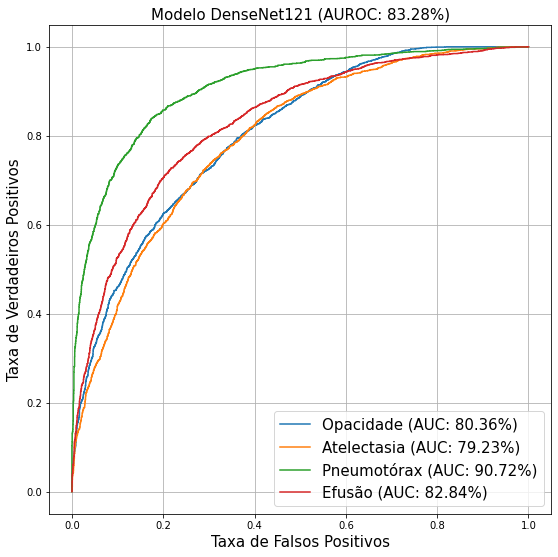

In [49]:
labels_portugues = ['Opacidade', 'Atelectasia', 'Pneumotórax', 'Efusão']
fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(y_labels_test2[:, idx].astype(int), y_pred2[:, idx])
    c_ax.plot(fpr, tpr, label = '{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize = 15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
auroc_value = str(roc_auc_score(y_labels_test2.astype(int), y_pred2) * 100)[0:5]
c_ax.set_title('Modelo DenseNet121 (AUROC: ' + auroc_value + '%)', size = 15)
c_ax.grid(True)

In [50]:
threshold_variation = dict()
for label_index in range(0, len(findings)):
  threshold_variation[label_index] = list()
  for threshold in range(1, 100):
    y_pred_bin2 = binarize_preds(pred_array = y_pred_val2, column = label_index, 
                                 threshold = threshold)
    matrix = confusion_matrix(y_labels_valid2[:, label_index], y_pred_bin2)
    acc = (matrix[0,0] + matrix[1,1])/np.sum(matrix)
    threshold_variation[label_index].append(acc)

bests_thresholds = list()
for label_index in range(0, len(findings)):
   for threshold in range(1, 100):
     if threshold_variation[label_index][threshold] == np.max(threshold_variation[label_index]):
       bests_thresholds.append(threshold)
       break

In [51]:
for label_index in range(0, len(findings)):
  y_pred_bin2 = binarize_preds(pred_array = y_pred2, column = label_index, 
                               threshold = bests_thresholds[label_index])
  matrix = confusion_matrix(y_labels_test2[:, label_index], y_pred_bin2)
  acc = (matrix[0,0] + matrix[1,1]) / np.sum(matrix)
  precision = matrix[0,0] / (matrix[0,0] + matrix[0,1])
  recall = matrix[0,0] / (matrix[0,0] + matrix[1,0])
  f1_score = (2 * precision * recall) / (precision + recall) 
  print(f'=={labels_portugues[label_index]}== \n{matrix},' 
        f' Threshold = {bests_thresholds[label_index]}'
        f'\nAcurácia = {acc * 100} % | Precisão = {precision * 100} % | '
        f'\nSensibilidade = {recall * 100} % | F1 Score = {f1_score * 100} %\n')

==Opacidade== 
[[1928  983]
 [ 695 2314]], Threshold = 43
Acurácia = 71.6554054054054 % | Precisão = 66.23153555479216 % | 
Sensibilidade = 73.50362180709111 % | F1 Score = 69.67835200578243 %

==Atelectasia== 
[[2310 1046]
 [ 652 1912]], Threshold = 39
Acurácia = 71.31756756756756 % | Precisão = 68.83194278903456 % | 
Sensibilidade = 77.98784604996624 % | F1 Score = 73.1244064577398 %

==Pneumotórax== 
[[2828  582]
 [ 426 2084]], Threshold = 15
Acurácia = 82.97297297297297 % | Precisão = 82.9325513196481 % | 
Sensibilidade = 86.90842040565457 % | F1 Score = 84.87394957983194 %

==Efusão== 
[[2291  807]
 [ 663 2159]], Threshold = 70
Acurácia = 75.16891891891892 % | Precisão = 73.95093608779858 % | 
Sensibilidade = 77.55585646580907 % | F1 Score = 75.7105089226702 %



### InceptionV3

In [ ]:
base_model3 = InceptionV3(include_top = False, weights = 'imagenet', 
                          input_shape = (image_size, image_size, 3))
x = base_model3.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(findings), activation = 'sigmoid')(x)
inception = tf.keras.Model(base_model3.input, output)
inception.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                  loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                  metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks(model_name = 'inception', monitor = 'val_auc_1')

In [57]:
layers_name = list()
for layer in base_model3.layers:
  layers_name.append(layer.name)

block_names = ['input_2', 'batch_normalization_80', 'mixed8']

for blocks in block_names:
  try:
    layers_name.index(blocks)
    print('Bloco ' + blocks + ' found!')
  except ValueError:
    print('Bloco ' + blocks + ' not found!')

Bloco input_2 found!
Bloco batch_normalization_80 found!
Bloco mixed8 found!


In [58]:
freeze_layers(conv_base = base_model3, layer_name = block_names[2])
inception.fit(train_gen3, validation_data = valid_gen3, epochs = 5, 
              callbacks = callbacks, use_multiprocessing = True, 
              workers = 8)

Epoch 1/5
1049/1049 [==============================] - ETA: 0s - loss: 0.5638 - auc_1: 0.7653
Epoch 1: val_auc_1 improved from -inf to 0.78318, saving model to model.inception.h5
1049/1049 [==============================] - 582s 543ms/step - loss: 0.5638 - auc_1: 0.7653 - val_loss: 0.5881 - val_auc_1: 0.7832
Epoch 2/5
1049/1049 [==============================] - ETA: 0s - loss: 0.5228 - auc_1: 0.8047
Epoch 2: val_auc_1 did not improve from 0.78318
1049/1049 [==============================] - 552s 520ms/step - loss: 0.5228 - auc_1: 0.8047 - val_loss: 0.6476 - val_auc_1: 0.7658
Epoch 3/5
1049/1049 [==============================] - ETA: 0s - loss: 0.5032 - auc_1: 0.8206
Epoch 3: val_auc_1 improved from 0.78318 to 0.80484, saving model to model.inception.h5
1049/1049 [==============================] - 547s 517ms/step - loss: 0.5032 - auc_1: 0.8206 - val_loss: 0.5608 - val_auc_1: 0.8048
Epoch 4/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4859 - auc_1: 0.8343
Epoch 4: v

In [ ]:
inception.load_weights('/content/model.inception.h5')
inception.save('model_inception1')
shutil.make_archive(base_name = 'model_inception1', format = 'zip', 
                    root_dir = '/content/model_inception1')
shutil.move('/content/model_inception1.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/InceptionV3')

In [60]:
freeze_layers(conv_base = base_model3, layer_name = block_names[1])
inception.fit(train_gen3, validation_data = valid_gen3, epochs = 5, 
              callbacks = callbacks, use_multiprocessing = True, 
              workers = 8)

Epoch 1/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4881 - auc_1: 0.8329
Epoch 1: val_auc_1 did not improve from 0.80484
1049/1049 [==============================] - 541s 512ms/step - loss: 0.4881 - auc_1: 0.8329 - val_loss: 0.6400 - val_auc_1: 0.7918
Epoch 2/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4702 - auc_1: 0.8459
Epoch 2: val_auc_1 improved from 0.80484 to 0.82208, saving model to model.inception.h5
1049/1049 [==============================] - 544s 514ms/step - loss: 0.4702 - auc_1: 0.8459 - val_loss: 0.5242 - val_auc_1: 0.8221
Epoch 3/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4518 - auc_1: 0.8585
Epoch 3: val_auc_1 improved from 0.82208 to 0.82863, saving model to model.inception.h5
1049/1049 [==============================] - 546s 516ms/step - loss: 0.4518 - auc_1: 0.8585 - val_loss: 0.5030 - val_auc_1: 0.8286
Epoch 4/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4333 - auc_1: 0.8707
Epoch 4

In [ ]:
inception.load_weights('/content/model.inception.h5')
inception.save('model_inception2')
shutil.make_archive(base_name = 'model_inception2', format = 'zip', 
                    root_dir = '/content/model_inception2')
shutil.move('/content/model_inception2.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/InceptionV3')

In [62]:
freeze_layers(conv_base = base_model3, layer_name = block_names[0])
inception.fit(train_gen3, validation_data = valid_gen3, epochs = 5, 
              callbacks = callbacks, use_multiprocessing = True, 
              workers = 8)

Epoch 1/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4270 - auc_1: 0.8747
Epoch 1: val_auc_1 did not improve from 0.82863
1049/1049 [==============================] - 541s 511ms/step - loss: 0.4270 - auc_1: 0.8747 - val_loss: 0.6561 - val_auc_1: 0.8198
Epoch 2/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4077 - auc_1: 0.8863
Epoch 2: val_auc_1 did not improve from 0.82863
1049/1049 [==============================] - 543s 511ms/step - loss: 0.4077 - auc_1: 0.8863 - val_loss: 0.5721 - val_auc_1: 0.8151
Epoch 3/5
1049/1049 [==============================] - ETA: 0s - loss: 0.3857 - auc_1: 0.8988
Epoch 3: val_auc_1 did not improve from 0.82863
1049/1049 [==============================] - 543s 514ms/step - loss: 0.3857 - auc_1: 0.8988 - val_loss: 0.6542 - val_auc_1: 0.8201
Epoch 4/5
1049/1049 [==============================] - ETA: 0s - loss: 0.3634 - auc_1: 0.9103
Epoch 4: val_auc_1 improved from 0.82863 to 0.84628, saving model to model.inception.h5

In [ ]:
inception.load_weights('/content/model.inception.h5')
inception.save('model_inception3')
shutil.make_archive(base_name = 'model_inception3', format = 'zip', 
                    root_dir = '/content/model_inception3')
shutil.move('/content/model_inception3.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/InceptionV3')

In [ ]:
shutil.move('/content/model.inception.h5', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/InceptionV3')

In [65]:
y_pred_val3 = inception.predict(valid_gen3)
y_pred3 = inception.predict(test_gen3)
print(f'AUC | Dados de Validação = {inception.evaluate(valid_gen3)[1] * 100} %')
print(f'AUC | Dados de Teste = {inception.evaluate(test_gen3)[1] * 100} %')

93/93 [==============================] - 33s 352ms/step - loss: 0.5107 - auc_1: 0.8463
AUC | Dados de Validação = 84.62808132171631 %
93/93 [==============================] - 33s 351ms/step - loss: 0.5119 - auc_1: 0.8446
AUC | Dados de Teste = 84.45929288864136 %


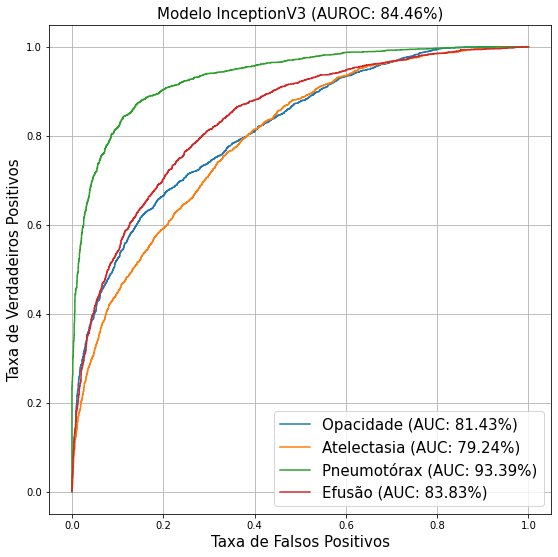

In [68]:
labels_portugues = ['Opacidade', 'Atelectasia', 'Pneumotórax', 'Efusão']
fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(y_labels_test3[:, idx].astype(int), y_pred3[:, idx])
    c_ax.plot(fpr, tpr, label = '{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize = 15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
auroc_value = str(roc_auc_score(y_labels_test3.astype(int), y_pred3) * 100)[0:5]
c_ax.set_title('Modelo InceptionV3 (AUROC: ' + auroc_value + '%)', size = 15)
c_ax.grid(True)

In [69]:
threshold_variation = dict()
for label_index in range(0, len(findings)):
  threshold_variation[label_index] = list()
  for threshold in range(1, 100):
    y_pred_bin3 = binarize_preds(pred_array = y_pred_val3, column = label_index, 
                                 threshold = threshold)
    matrix = confusion_matrix(y_labels_valid3[:, label_index], y_pred_bin3)
    acc = (matrix[0,0] + matrix[1,1]) / np.sum(matrix)
    threshold_variation[label_index].append(acc)

bests_thresholds = list()
for label_index in range(0, len(findings)):
   for threshold in range(1, 100):
     if threshold_variation[label_index][threshold] == np.max(threshold_variation[label_index]):
       bests_thresholds.append(threshold)
       break

In [70]:
for label_index in range(0, len(findings)):
  y_pred_bin3 = binarize_preds(pred_array = y_pred3, column = label_index, 
                               threshold = bests_thresholds[label_index])
  matrix = confusion_matrix(y_labels_test3[:, label_index], y_pred_bin3)
  acc = (matrix[0,0] + matrix[1,1]) / np.sum(matrix)
  precision = matrix[0,0] / (matrix[0,0] + matrix[0,1])
  recall = matrix[0,0] / (matrix[0,0] + matrix[1,0])
  f1_score = (2 * precision * recall) / (precision + recall) 
  print(f'=={labels_portugues[label_index]}== \n{matrix},' 
        f' Threshold = {bests_thresholds[label_index]}'
        f'\nAcurácia = {acc * 100} % | Precisão = {precision * 100} % | '
        f'\nSensibilidade = {recall * 100} % | F1 Score = {f1_score * 100} %\n')

==Opacidade== 
[[1978  933]
 [ 738 2271]], Threshold = 47
Acurácia = 71.77364864864865 % | Precisão = 67.94915836482308 % | 
Sensibilidade = 72.82768777614137 % | F1 Score = 70.30389194952905 %

==Atelectasia== 
[[2492  864]
 [ 884 1680]], Threshold = 67
Acurácia = 70.47297297297297 % | Precisão = 74.25506555423122 % | 
Sensibilidade = 73.81516587677726 % | F1 Score = 74.03446226975639 %

==Pneumotórax== 
[[3053  357]
 [ 436 2074]], Threshold = 41
Acurácia = 86.60472972972974 % | Precisão = 89.5307917888563 % | 
Sensibilidade = 87.50358268844941 % | F1 Score = 88.50558051891578 %

==Efusão== 
[[2285  813]
 [ 630 2192]], Threshold = 60
Acurácia = 75.625 % | Precisão = 73.75726275016139 % | 
Sensibilidade = 78.3876500857633 % | F1 Score = 76.00199567603525 %



### Xception

In [ ]:
base_model4 = Xception(include_top = False, weights = 'imagenet', 
                       input_shape = (image_size, image_size, 3))
x = base_model4.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(findings), activation = 'sigmoid')(x)
xception = tf.keras.Model(base_model4.input, output)
xception.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                 loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                 metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks(model_name = 'xception', monitor = 'val_auc_2')

In [73]:
layers_name = list()
for layer in base_model4.layers:
  layers_name.append(layer.name)

block_names = ['input_3', 'block6_sepconv3_act', 'block11_sepconv3_bn']

for blocks in block_names:
  try:
    layers_name.index(blocks)
    print('Bloco ' + blocks + ' found!')
  except ValueError:
    print('Bloco ' + blocks + ' not found!')

Bloco input_3 found!
Bloco block6_sepconv3_act found!
Bloco block11_sepconv3_bn found!


In [74]:
freeze_layers(conv_base = base_model4, layer_name = block_names[2])
xception.fit(train_gen4, validation_data = valid_gen4, epochs = 5, 
             callbacks = callbacks, use_multiprocessing = True, 
             workers = 8)

Epoch 1/5
1049/1049 [==============================] - ETA: 0s - loss: 0.5413 - auc_2: 0.7881
Epoch 1: val_auc_2 improved from -inf to 0.73587, saving model to model.xception.h5
1049/1049 [==============================] - 850s 799ms/step - loss: 0.5413 - auc_2: 0.7881 - val_loss: 1.1792 - val_auc_2: 0.7359
Epoch 2/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4959 - auc_2: 0.8263
Epoch 2: val_auc_2 improved from 0.73587 to 0.79971, saving model to model.xception.h5
1049/1049 [==============================] - 825s 780ms/step - loss: 0.4959 - auc_2: 0.8263 - val_loss: 0.6288 - val_auc_2: 0.7997
Epoch 3/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4716 - auc_2: 0.8445
Epoch 3: val_auc_2 improved from 0.79971 to 0.81505, saving model to model.xception.h5
1049/1049 [==============================] - 824s 780ms/step - loss: 0.4716 - auc_2: 0.8445 - val_loss: 0.5785 - val_auc_2: 0.8151
Epoch 4/5
1049/1049 [==============================] - ETA: 0s - lo

In [ ]:
xception.load_weights('/content/model.xception.h5')
xception.save('model_xception1')
shutil.make_archive(base_name = 'model_xception1', format = 'zip', 
                    root_dir = '/content/model_xception1')
shutil.move('/content/model_xception1.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/Xception')

In [76]:
freeze_layers(conv_base = base_model4, layer_name = block_names[1])
xception.fit(train_gen4, validation_data = valid_gen4, epochs = 5, 
             callbacks = callbacks, use_multiprocessing = True, 
             workers = 8)

Epoch 1/5
1049/1049 [==============================] - ETA: 0s - loss: 0.3832 - auc_2: 0.9003
Epoch 1: val_auc_2 did not improve from 0.85268
1049/1049 [==============================] - 823s 779ms/step - loss: 0.3832 - auc_2: 0.9003 - val_loss: 0.5222 - val_auc_2: 0.8433
Epoch 2/5
1049/1049 [==============================] - ETA: 0s - loss: 0.3485 - auc_2: 0.9179
Epoch 2: val_auc_2 improved from 0.85268 to 0.87416, saving model to model.xception.h5
1049/1049 [==============================] - 826s 782ms/step - loss: 0.3485 - auc_2: 0.9179 - val_loss: 0.4555 - val_auc_2: 0.8742
Epoch 3/5
1049/1049 [==============================] - ETA: 0s - loss: 0.3136 - auc_2: 0.9335
Epoch 3: val_auc_2 did not improve from 0.87416
1049/1049 [==============================] - 823s 779ms/step - loss: 0.3136 - auc_2: 0.9335 - val_loss: 0.5501 - val_auc_2: 0.8622
Epoch 4/5
1049/1049 [==============================] - ETA: 0s - loss: 0.2820 - auc_2: 0.9466
Epoch 4: val_auc_2 improved from 0.87416 to 0.87

In [ ]:
xception.load_weights('/content/model.xception.h5')
xception.save('model_xception2')
shutil.make_archive(base_name = 'model_xception2', format = 'zip', 
                    root_dir = '/content/model_xception2')
shutil.move('/content/model_xception2.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/Xception')

In [78]:
freeze_layers(conv_base = base_model4, layer_name = block_names[0])
xception.fit(train_gen4, validation_data = valid_gen4, epochs = 5, 
             callbacks = callbacks, use_multiprocessing = True, 
             workers = 8)

Epoch 1/5
1049/1049 [==============================] - ETA: 0s - loss: 0.2472 - auc_2: 0.9587
Epoch 1: val_auc_2 did not improve from 0.87418
1049/1049 [==============================] - 824s 781ms/step - loss: 0.2472 - auc_2: 0.9587 - val_loss: 0.6184 - val_auc_2: 0.8683
Epoch 2/5
1049/1049 [==============================] - ETA: 0s - loss: 0.2224 - auc_2: 0.9666
Epoch 2: val_auc_2 improved from 0.87418 to 0.89064, saving model to model.xception.h5
1049/1049 [==============================] - 824s 781ms/step - loss: 0.2224 - auc_2: 0.9666 - val_loss: 0.4720 - val_auc_2: 0.8906
Epoch 3/5
1049/1049 [==============================] - ETA: 0s - loss: 0.2005 - auc_2: 0.9728
Epoch 3: val_auc_2 did not improve from 0.89064
1049/1049 [==============================] - 828s 784ms/step - loss: 0.2005 - auc_2: 0.9728 - val_loss: 0.5844 - val_auc_2: 0.8810
Epoch 4/5
1049/1049 [==============================] - ETA: 0s - loss: 0.1806 - auc_2: 0.9779
Epoch 4: val_auc_2 did not improve from 0.89064


In [ ]:
xception.load_weights('/content/model.xception.h5')
xception.save('model_xception3')
shutil.make_archive(base_name = 'model_xception3', format = 'zip', 
                    root_dir = '/content/model_xception3')
shutil.move('/content/model_xception3.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/Xception')

In [ ]:
shutil.move('/content/model.xception.h5', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/Xception')

In [81]:
y_pred_val4 = xception.predict(valid_gen4)
y_pred4 = xception.predict(test_gen4)
print(f'AUC | Dados de Validação = {xception.evaluate(valid_gen4)[1] * 100} %')
print(f'AUC | Dados de Teste = {xception.evaluate(test_gen4)[1] * 100} %')

93/93 [==============================] - 34s 369ms/step - loss: 0.4906 - auc_2: 0.8952
AUC | Dados de Validação = 89.52452540397644 %
93/93 [==============================] - 34s 363ms/step - loss: 0.4916 - auc_2: 0.8929
AUC | Dados de Teste = 89.28844928741455 %


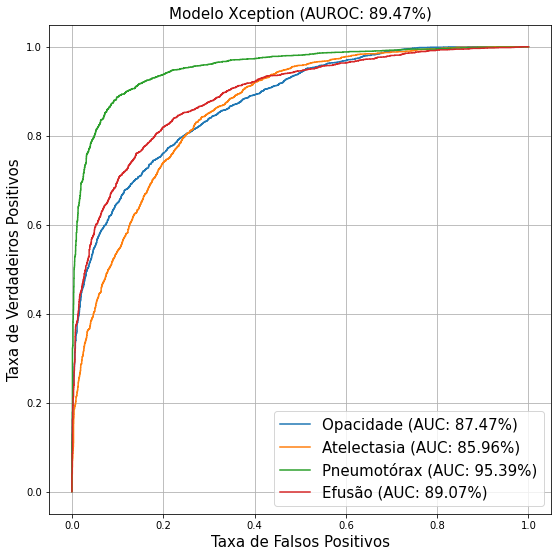

In [82]:
labels_portugues = ['Opacidade', 'Atelectasia', 'Pneumotórax', 'Efusão']
fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(y_labels_test4[:, idx].astype(int), y_pred4[:, idx])
    c_ax.plot(fpr, tpr, label = '{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize = 15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
auroc_value = str(roc_auc_score(y_labels_test4.astype(int), y_pred4) * 100)[0:5]
c_ax.set_title('Modelo Xception (AUROC: ' + auroc_value + '%)', size = 15)
c_ax.grid(True)

In [83]:
threshold_variation = dict()
for label_index in range(0, len(findings)):
  threshold_variation[label_index] = list()
  for threshold in range(1, 100):
    y_pred_bin4 = binarize_preds(pred_array = y_pred_val4, column = label_index, 
                                 threshold = threshold)
    matrix = confusion_matrix(y_labels_valid4[:, label_index], y_pred_bin4)
    acc = (matrix[0,0] + matrix[1,1]) / np.sum(matrix)
    threshold_variation[label_index].append(acc)

bests_thresholds = list()
for label_index in range(0, len(findings)):
   for threshold in range(1, 100):
     if threshold_variation[label_index][threshold] == np.max(threshold_variation[label_index]):
       bests_thresholds.append(threshold)
       break

In [84]:
for label_index in range(0, len(findings)):
  y_pred_bin4 = binarize_preds(pred_array = y_pred4, column = label_index, 
                               threshold = bests_thresholds[label_index])
  matrix = confusion_matrix(y_labels_test4[:, label_index], y_pred_bin4)
  acc = (matrix[0,0] + matrix[1,1]) / np.sum(matrix)
  precision = matrix[0,0] / (matrix[0,0] + matrix[0,1])
  recall = matrix[0,0] / (matrix[0,0]+matrix[1,0])
  f1_score = (2 * precision * recall) / (precision + recall)
  print(f'=={labels_portugues[label_index]}== \n{matrix},'
        f' Threshold = {bests_thresholds[label_index]}'
        f'\nAcurácia = {acc * 100} % | Precisão = {precision * 100} % | '
        f'\nSensibilidade = {recall * 100} % | F1 Score = {f1_score * 100} %\n')

==Opacidade== 
[[2527  384]
 [ 922 2087]], Threshold = 65
Acurácia = 77.93918918918918 % | Precisão = 86.80865681896256 % | 
Sensibilidade = 73.26761380110177 % | F1 Score = 79.46540880503146 %

==Atelectasia== 
[[2709  647]
 [ 698 1866]], Threshold = 36
Acurácia = 77.2804054054054 % | Precisão = 80.72109654350416 % | 
Sensibilidade = 79.5127678309363 % | F1 Score = 80.11237616442406 %

==Pneumotórax== 
[[3186  224]
 [ 410 2100]], Threshold = 55
Acurácia = 89.29054054054055 % | Precisão = 93.43108504398828 % | 
Sensibilidade = 88.59844271412682 % | F1 Score = 90.9506137596346 %

==Efusão== 
[[2591  507]
 [ 620 2202]], Threshold = 54
Acurácia = 80.96283783783784 % | Precisão = 83.63460296965785 % | 
Sensibilidade = 80.69137340392402 % | F1 Score = 82.13663021080995 %



### InceptionResNetV2

In [ ]:
base_model5 = InceptionResNetV2(include_top = False, weights = 'imagenet', 
                                input_shape = (image_size, image_size, 3))
x = base_model5.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(findings), activation = 'sigmoid')(x)
inceptionresnet = tf.keras.Model(base_model5.input, output)
inceptionresnet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                        metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks(model_name = 'inceptionresnet', monitor = 'val_auc_3')

In [87]:
layers_name = list()
for layer in base_model5.layers:
  layers_name.append(layer.name)

block_names = ['input_4', 'activation_180', 'batch_normalization_202']

for blocks in block_names:
  try:
    layers_name.index(blocks)
    print('Bloco ' + blocks + ' found!')
  except ValueError:
    print('Bloco ' + blocks + ' not found!')

Bloco input_4 found!
Bloco activation_180 found!
Bloco batch_normalization_202 found!


In [88]:
freeze_layers(conv_base = base_model5, layer_name = block_names[2])
inceptionresnet.fit(train_gen5, validation_data = valid_gen5, epochs = 5, 
                    callbacks = callbacks, use_multiprocessing = True, 
                    workers = 8)

Epoch 1/5
1049/1049 [==============================] - ETA: 0s - loss: 0.5510 - auc_3: 0.7791
Epoch 1: val_auc_3 improved from -inf to 0.71370, saving model to model.inceptionresnet.h5
1049/1049 [==============================] - 708s 650ms/step - loss: 0.5510 - auc_3: 0.7791 - val_loss: 0.7433 - val_auc_3: 0.7137
Epoch 2/5
1049/1049 [==============================] - ETA: 0s - loss: 0.5121 - auc_3: 0.8132
Epoch 2: val_auc_3 did not improve from 0.71370
1049/1049 [==============================] - 663s 627ms/step - loss: 0.5121 - auc_3: 0.8132 - val_loss: 1.2949 - val_auc_3: 0.5075
Epoch 3/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4897 - auc_3: 0.8313
Epoch 3: val_auc_3 improved from 0.71370 to 0.81489, saving model to model.inceptionresnet.h5
1049/1049 [==============================] - 665s 629ms/step - loss: 0.4897 - auc_3: 0.8313 - val_loss: 0.5306 - val_auc_3: 0.8149
Epoch 4/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4701 - auc_3: 0.845

In [ ]:
inceptionresnet.load_weights('/content/model.inceptionresnet.h5')
inceptionresnet.save('model_inceptionresnet1')
shutil.make_archive(base_name = 'model_inceptionresnet1', format = 'zip', 
                    root_dir = '/content/model_inceptionresnet1')
shutil.move('/content/model_inceptionresnet1.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/InceptionResNetV2')

In [90]:
freeze_layers(conv_base = base_model5, layer_name = block_names[1])
inceptionresnet.fit(train_gen5, validation_data = valid_gen5, epochs = 5, 
                    callbacks = callbacks, use_multiprocessing = True, 
                    workers = 8)

Epoch 1/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4226 - auc_3: 0.8773
Epoch 1: val_auc_3 did not improve from 0.83739
1049/1049 [==============================] - 665s 629ms/step - loss: 0.4226 - auc_3: 0.8773 - val_loss: 1.1259 - val_auc_3: 0.7514
Epoch 2/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4019 - auc_3: 0.8898
Epoch 2: val_auc_3 improved from 0.83739 to 0.85788, saving model to model.inceptionresnet.h5
1049/1049 [==============================] - 672s 634ms/step - loss: 0.4019 - auc_3: 0.8898 - val_loss: 0.4678 - val_auc_3: 0.8579
Epoch 3/5
1049/1049 [==============================] - ETA: 0s - loss: 0.3703 - auc_3: 0.9070
Epoch 3: val_auc_3 improved from 0.85788 to 0.86189, saving model to model.inceptionresnet.h5
1049/1049 [==============================] - 687s 648ms/step - loss: 0.3703 - auc_3: 0.9070 - val_loss: 0.5545 - val_auc_3: 0.8619
Epoch 4/5
1049/1049 [==============================] - ETA: 0s - loss: 0.3380 - auc_3: 0.

In [ ]:
inceptionresnet.load_weights('/content/model.inceptionresnet.h5')
inceptionresnet.save('model_inceptionresnet2')
shutil.make_archive(base_name = 'model_inceptionresnet2', format = 'zip', 
                    root_dir = '/content/model_inceptionresnet2')
shutil.move('/content/model_inceptionresnet2.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/InceptionResNetV2')

In [92]:
freeze_layers(conv_base = base_model5, layer_name = block_names[0])
inceptionresnet.fit(train_gen5, validation_data = valid_gen5, epochs = 5, 
                    callbacks = callbacks, use_multiprocessing = True, 
                    workers = 8)

Epoch 1/5
1049/1049 [==============================] - ETA: 0s - loss: 0.2783 - auc_3: 0.9479
Epoch 1: val_auc_3 improved from 0.87231 to 0.87895, saving model to model.inceptionresnet.h5
1049/1049 [==============================] - 714s 676ms/step - loss: 0.2783 - auc_3: 0.9479 - val_loss: 0.4731 - val_auc_3: 0.8790
Epoch 2/5
1049/1049 [==============================] - ETA: 0s - loss: 0.2616 - auc_3: 0.9539
Epoch 2: val_auc_3 did not improve from 0.87895
1049/1049 [==============================] - 695s 655ms/step - loss: 0.2616 - auc_3: 0.9539 - val_loss: 0.4619 - val_auc_3: 0.8762
Epoch 3/5
1049/1049 [==============================] - ETA: 0s - loss: 0.2344 - auc_3: 0.9629
Epoch 3: val_auc_3 did not improve from 0.87895
1049/1049 [==============================] - 677s 641ms/step - loss: 0.2344 - auc_3: 0.9629 - val_loss: 0.6649 - val_auc_3: 0.8107
Epoch 4/5
1049/1049 [==============================] - ETA: 0s - loss: 0.2073 - auc_3: 0.9711
Epoch 4: val_auc_3 improved from 0.87895 

In [ ]:
inceptionresnet.load_weights('/content/model.inceptionresnet.h5')
inceptionresnet.save('model_inceptionresnet3')
shutil.make_archive(base_name = 'model_inceptionresnet3', format = 'zip', 
                    root_dir = '/content/model_inceptionresnet3')
shutil.move('/content/model_inceptionresnet3.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/InceptionResNetV2')

In [ ]:
shutil.move('/content/model.inceptionresnet.h5', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/InceptionResNetV2')

In [95]:
y_pred_val5 = inceptionresnet.predict(valid_gen5)
y_pred5 = inceptionresnet.predict(test_gen5)
print(f'AUC | Dados de Validação = {inceptionresnet.evaluate(valid_gen5)[1] * 100} %')
print(f'AUC | Dados de Teste = {inceptionresnet.evaluate(test_gen5)[1] * 100} %')

93/93 [==============================] - 35s 373ms/step - loss: 0.4726 - auc_3: 0.8893
AUC | Dados de Validação = 88.92983198165894 %
93/93 [==============================] - 35s 374ms/step - loss: 0.4718 - auc_3: 0.8876
AUC | Dados de Teste = 88.76354694366455 %


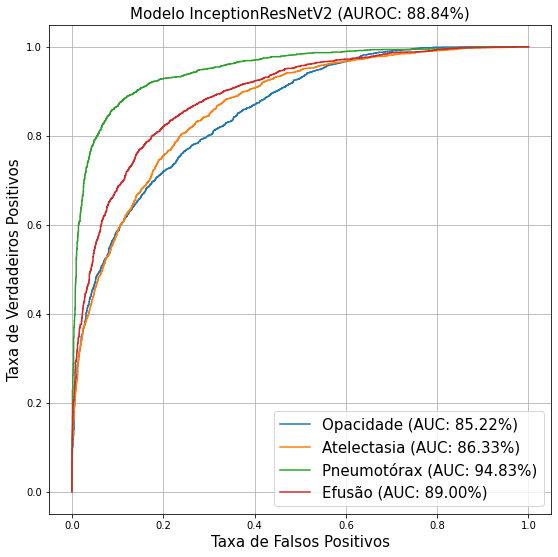

In [96]:
labels_portugues = ['Opacidade', 'Atelectasia', 'Pneumotórax', 'Efusão']
fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(y_labels_test5[:, idx].astype(int), y_pred5[:, idx])
    c_ax.plot(fpr, tpr, label = '{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize = 15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
auroc_value = str(roc_auc_score(y_labels_test5.astype(int), y_pred5) * 100)[0:5]
c_ax.set_title('Modelo InceptionResNetV2 (AUROC: ' + auroc_value + '%)', size = 15)
c_ax.grid(True)

In [97]:
threshold_variation = dict()
for label_index in range(0, len(count_findings)):
  threshold_variation[label_index] = list()
  for threshold in range(1, 100):
    y_pred_bin5 = binarize_preds(pred_array = y_pred_val5, column = label_index, 
                                 threshold = threshold)
    matrix = confusion_matrix(y_labels_valid5[:, label_index], y_pred_bin5)
    acc = (matrix[0,0] + matrix[1,1]) / np.sum(matrix)
    threshold_variation[label_index].append(acc)

bests_thresholds = list()
for label_index in range(0, len(findings)):
   for threshold in range(1, 100):
     if threshold_variation[label_index][threshold] == np.max(threshold_variation[label_index]):
       bests_thresholds.append(threshold)
       break

In [99]:
for label_index in range(0, len(findings)):
  y_pred_bin5 = binarize_preds(pred_array = y_pred5, column = label_index, 
                               threshold = bests_thresholds[label_index])
  matrix = confusion_matrix(y_labels_test5[:, label_index], y_pred_bin5)
  acc = (matrix[0,0] + matrix[1,1]) / np.sum(matrix)
  precision = matrix[0,0] / (matrix[0,0] + matrix[0,1])
  recall = matrix[0,0] / (matrix[0,0] + matrix[1,0])
  f1_score = (2 * precision * recall) / (precision + recall) 
  print(f'=={labels_portugues[label_index]}== \n{matrix},' 
        f' Threshold = {bests_thresholds[label_index]}'
        f'\nAcurácia = {acc * 100} % | Precisão = {precision * 100} % | '
        f'\nSensibilidade = {recall * 100} % | F1 Score = {f1_score * 100} %\n')

==Opacidade== 
[[2308  603]
 [ 828 2181]], Threshold = 51
Acurácia = 75.82770270270271 % | Precisão = 79.28546891102714 % | 
Sensibilidade = 73.5969387755102 % | F1 Score = 76.33537291218786 %

==Atelectasia== 
[[2699  657]
 [ 644 1920]], Threshold = 29
Acurácia = 78.02364864864865 % | Precisão = 80.42312276519667 % | 
Sensibilidade = 80.73586598863297 % | F1 Score = 80.57919092401852 %

==Pneumotórax== 
[[3108  302]
 [ 356 2154]], Threshold = 51
Acurácia = 88.88513513513514 % | Precisão = 91.14369501466275 % | 
Sensibilidade = 89.72286374133948 % | F1 Score = 90.4276985743381 %

==Efusão== 
[[2619  479]
 [ 640 2182]], Threshold = 37
Acurácia = 81.09797297297298 % | Precisão = 84.53841187863136 % | 
Sensibilidade = 80.36207425590672 % | F1 Score = 82.39735724398301 %



### ResNet101V2

In [ ]:
base_model6 = ResNet101V2(include_top = False, weights = 'imagenet', 
                          input_shape = (image_size, image_size, 3))
x = base_model6.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(findings), activation = 'sigmoid')(x)
resnet = tf.keras.Model(base_model6.input, output)
resnet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
               loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
               metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks(model_name = 'resnet', monitor = 'val_auc_4')

In [103]:
layers_name = list()
for layer in base_model6.layers:
  layers_name.append(layer.name)

block_names = ['input_5', 'conv3_block4_1_conv', 'conv4_block6_3_conv']

for blocks in block_names:
  try:
    layers_name.index(blocks)
    print('Bloco ' + blocks + ' found!')
  except ValueError:
    print('Bloco ' + blocks + ' not found!')

Bloco input_5 found!
Bloco conv3_block4_1_conv found!
Bloco conv4_block6_3_conv found!


In [104]:
freeze_layers(conv_base = base_model6, layer_name = block_names[2])
resnet.fit(train_gen6, validation_data = valid_gen6, epochs = 5, 
           callbacks = callbacks, use_multiprocessing = True, 
           workers = 8)

Epoch 1/5
1049/1049 [==============================] - ETA: 0s - loss: 0.5936 - auc_4: 0.7330
Epoch 1: val_auc_4 improved from -inf to 0.73226, saving model to model.resnet.h5
1049/1049 [==============================] - 646s 600ms/step - loss: 0.5936 - auc_4: 0.7330 - val_loss: 0.6137 - val_auc_4: 0.7323
Epoch 2/5
1049/1049 [==============================] - ETA: 0s - loss: 0.5537 - auc_4: 0.7759
Epoch 2: val_auc_4 improved from 0.73226 to 0.76552, saving model to model.resnet.h5
1049/1049 [==============================] - 615s 582ms/step - loss: 0.5537 - auc_4: 0.7759 - val_loss: 0.6155 - val_auc_4: 0.7655
Epoch 3/5
1049/1049 [==============================] - ETA: 0s - loss: 0.5355 - auc_4: 0.7930
Epoch 3: val_auc_4 improved from 0.76552 to 0.78984, saving model to model.resnet.h5
1049/1049 [==============================] - 612s 579ms/step - loss: 0.5355 - auc_4: 0.7930 - val_loss: 0.5775 - val_auc_4: 0.7898
Epoch 4/5
1049/1049 [==============================] - ETA: 0s - loss: 0.

In [ ]:
resnet.load_weights('/content/model.resnet.h5')
resnet.save('model_resnet1')
shutil.make_archive(base_name = 'model_resnet1', format = 'zip', 
                    root_dir = '/content/model_resnet1')
shutil.move('/content/model_resnet1.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/ResNet101V2')

In [106]:
freeze_layers(conv_base = base_model6, layer_name = block_names[1])
resnet.fit(train_gen6, validation_data = valid_gen6, epochs = 5, 
           callbacks = callbacks, use_multiprocessing = True, 
           workers = 8)

Epoch 1/5
1049/1049 [==============================] - ETA: 0s - loss: 0.5281 - auc_4: 0.7997
Epoch 1: val_auc_4 did not improve from 0.78984
1049/1049 [==============================] - 603s 570ms/step - loss: 0.5281 - auc_4: 0.7997 - val_loss: 0.7291 - val_auc_4: 0.7559
Epoch 2/5
1049/1049 [==============================] - ETA: 0s - loss: 0.5138 - auc_4: 0.8118
Epoch 2: val_auc_4 did not improve from 0.78984
1049/1049 [==============================] - 603s 569ms/step - loss: 0.5138 - auc_4: 0.8118 - val_loss: 0.7096 - val_auc_4: 0.7477
Epoch 3/5
1049/1049 [==============================] - ETA: 0s - loss: 0.5018 - auc_4: 0.8217
Epoch 3: val_auc_4 did not improve from 0.78984
1049/1049 [==============================] - 618s 585ms/step - loss: 0.5018 - auc_4: 0.8217 - val_loss: 0.8122 - val_auc_4: 0.7094
Epoch 4/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4920 - auc_4: 0.8292
Epoch 4: val_auc_4 did not improve from 0.78984
1049/1049 [============================

In [ ]:
resnet.load_weights('/content/model.resnet.h5')
resnet.save('model_resnet2')
shutil.make_archive(base_name = 'model_resnet2', format = 'zip', 
                    root_dir = '/content/model_resnet2')
shutil.move('/content/model_resnet2.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/ResNet101V2')

In [108]:
freeze_layers(conv_base = base_model6, layer_name = block_names[0])
resnet.fit(train_gen6, validation_data = valid_gen6, epochs = 5, 
           callbacks = callbacks, use_multiprocessing = True, 
           workers = 8)

Epoch 1/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4685 - auc_4: 0.8470
Epoch 1: val_auc_4 did not improve from 0.80431
1049/1049 [==============================] - 696s 655ms/step - loss: 0.4685 - auc_4: 0.8470 - val_loss: 0.7351 - val_auc_4: 0.7272
Epoch 2/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4558 - auc_4: 0.8559
Epoch 2: val_auc_4 improved from 0.80431 to 0.80476, saving model to model.resnet.h5
1049/1049 [==============================] - 628s 593ms/step - loss: 0.4558 - auc_4: 0.8559 - val_loss: 0.5600 - val_auc_4: 0.8048
Epoch 3/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4427 - auc_4: 0.8647
Epoch 3: val_auc_4 improved from 0.80476 to 0.82805, saving model to model.resnet.h5
1049/1049 [==============================] - 625s 591ms/step - loss: 0.4427 - auc_4: 0.8647 - val_loss: 0.5066 - val_auc_4: 0.8281
Epoch 4/5
1049/1049 [==============================] - ETA: 0s - loss: 0.4262 - auc_4: 0.8756
Epoch 4: val_

In [ ]:
resnet.load_weights('/content/model.resnet.h5')
resnet.save('model_resnet3')
shutil.make_archive(base_name = 'model_resnet3', format = 'zip', 
                    root_dir = '/content/model_resnet3')
shutil.move('/content/model_resnet3.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/ResNet101V2')

In [ ]:
shutil.move('/content/model.resnet.h5', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/ResNet101V2')

In [111]:
y_pred_val6 = resnet.predict(valid_gen6)
y_pred6 = resnet.predict(test_gen6)
print(f'AUC | Dados de Validação = {resnet.evaluate(valid_gen6)[1] * 100} %')
print(f'AUC | Dados de Teste = {resnet.evaluate(test_gen6)[1] * 100} %')

93/93 [==============================] - 35s 375ms/step - loss: 0.5000 - auc_4: 0.8471
AUC | Dados de Validação = 84.70889925956726 %
93/93 [==============================] - 35s 377ms/step - loss: 0.4965 - auc_4: 0.8482
AUC | Dados de Teste = 84.81748104095459 %


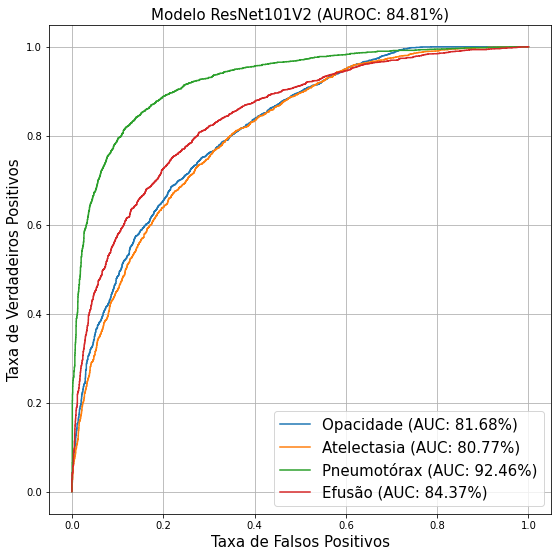

In [112]:
labels_portugues = ['Opacidade', 'Atelectasia', 'Pneumotórax', 'Efusão']
fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(y_labels_test6[:, idx].astype(int), y_pred6[:, idx])
    c_ax.plot(fpr, tpr, label = '{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize = 15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
auroc_value = str(roc_auc_score(y_labels_test6.astype(int), y_pred6) * 100)[0:5]
c_ax.set_title('Modelo ResNet101V2 (AUROC: ' + auroc_value + '%)', size = 15)
c_ax.grid(True)

In [113]:
threshold_variation = dict()
for label_index in range(0, len(findings)):
  threshold_variation[label_index] = list()
  for threshold in range(1, 100):
    y_pred_bin6 = binarize_preds(pred_array = y_pred_val6, column = label_index, 
                                 threshold = threshold)
    matrix = confusion_matrix(y_labels_valid6[:, label_index], y_pred_bin6)
    acc = (matrix[0,0] + matrix[1,1]) / np.sum(matrix)
    threshold_variation[label_index].append(acc)

bests_thresholds = list()
for label_index in range(0, len(findings)):
   for threshold in range(1, 100):
     if threshold_variation[label_index][threshold] == np.max(threshold_variation[label_index]):
       bests_thresholds.append(threshold)
       break

In [114]:
for label_index in range(0, len(findings)):
  y_pred_bin6 = binarize_preds(pred_array = y_pred6, column = label_index, 
                               threshold = bests_thresholds[label_index])
  matrix = confusion_matrix(y_labels_test6[:, label_index], y_pred_bin6)
  acc = (matrix[0,0] + matrix[1,1]) / np.sum(matrix)
  precision = matrix[0,0] / (matrix[0,0] + matrix[0,1])
  recall = matrix[0,0] / (matrix[0,0] + matrix[1,0])
  f1_score = (2 * precision * recall) / (precision + recall) 
  print(f'=={labels_portugues[label_index]}== \n{matrix},' 
        f' Threshold = {bests_thresholds[label_index]}'
        f'\nAcurácia = {acc * 100} % | Precisão = {precision * 100} % | '
        f'\nSensibilidade = {recall * 100} % | F1 Score = {f1_score * 100} %\n')

==Opacidade== 
[[2299  612]
 [ 993 2016]], Threshold = 50
Acurácia = 72.88851351351352 % | Precisão = 78.97629680522157 % | 
Sensibilidade = 69.8359659781288 % | F1 Score = 74.12542318233115 %

==Atelectasia== 
[[2667  689]
 [ 913 1651]], Threshold = 67
Acurácia = 72.9391891891892 % | Precisão = 79.46960667461263 % | 
Sensibilidade = 74.4972067039106 % | F1 Score = 76.90311418685121 %

==Pneumotórax== 
[[3054  356]
 [ 510 2000]], Threshold = 41
Acurácia = 85.37162162162161 % | Precisão = 89.56011730205279 % | 
Sensibilidade = 85.6902356902357 % | F1 Score = 87.5824490966447 %

==Efusão== 
[[2471  627]
 [ 766 2056]], Threshold = 66
Acurácia = 76.4695945945946 % | Precisão = 79.76113621691414 % | 
Sensibilidade = 76.33611368551128 % | F1 Score = 78.01104972375691 %

